# Decision Trees and Ensembles

----


## Introduction

In this assignment we will visualize the performance of complex models. The models are ensembles of decision trees (random forests) to automatically discover the non-linear relations between financial signals and stock returns. The objective of the model is to predict future stock returns based on historical attributes of a company's fundamental data.

We model the relationship first as a regression where we attempt to predict the actual return. Then, we frame the problem as a classification model where we attempt to simply predict if the return will be positive or negative.

This assignment will have you use visualization methods to understand:
* full end-to-end real world predictive analyses
* the feature space for a complex modeling task
* the relative importance of features in the predictor set
* the outputs for regression and classifications models

There is very little in the way of coding for the assignment. The complexity of the code is only to get you acquainted with using visualizations to make sense of unfamiliar and highly complex models.  

This example uses fundamental data of companies in the SP500. We will be pulling data from the SimFin library: [SimFin](https://github.com/SimFin/simfin). Be sure to run all the code cells in order before answering the questions below.

## Environment and Data Setup

In [ ]:
%load_ext google.colab.data_table

In [ ]:
import sys

if 'google.colab' in sys.modules:
  !pip install simfin


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 625.4 kB/s eta 0:00:00


In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

# Scikit-learn imports.
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import export_text
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score, accuracy_score

# Import the main functionality from the SimFin Python API.
import simfin as sf

# Import names used for easy access to SimFin's data-columns.
from simfin.names import *

import seaborn as sns

### SimFin Config

In [ ]:
# Installation: pip install simfin
# import simfin package
import simfin as sf

# Set your API-key for downloading data.
sf.set_api_key('d7544464-0743-4c7c-8408-82335dd60d1b')

# Set the local directory where data-files are stored.
# The directory will be created if it does not already exist.
sf.set_data_dir('~/simfin_data/')

# Download the data from the SimFin server and load into a Pandas DataFrame.
df = sf.load_income_insurance(variant='quarterly')

# Print the first rows of the data.
print(df.head())

Dataset "us-income-insurance-quarterly" not on disk.
- Downloading ... 100.0%
- Extracting zip-file ... Done!
- Loading from disk ... Done!
                    SimFinId Currency  Fiscal Year Fiscal Period Publish Date  \
Ticker Report Date                                                              
AAME   2017-12-31     450021      USD         2017            Q4   2018-03-26   
       2018-03-31     450021      USD         2018            Q1   2018-05-11   
       2018-06-30     450021      USD         2018            Q2   2018-08-14   
       2018-09-30     450021      USD         2018            Q3   2018-11-13   
       2018-12-31     450021      USD         2018            Q4   2019-04-01   

                   Restated Date  Shares (Basic)  Shares (Diluted)   Revenue  \
Ticker Report Date                                                             
AAME   2017-12-31     2018-03-26        20440000          20440000  46709000   
       2018-03-31     2018-05-11        20419000    

In [ ]:
%%time
# Data for USA.
market = 'us'

# TTM Income Statements.
df_income_ttm = sf.load_income_insurance(variant='ttm', market=market)

# Quarterly Income Statements.
df_income_qrt = sf.load_income_insurance(variant='quarterly', market=market)

# TTM Balance Sheets.
df_balance_ttm = sf.load_balance_insurance(variant='ttm', market=market)

# Quarterly Balance Sheets.
df_balance_qrt = sf.load_balance_insurance(variant='quarterly', market=market)

# TTM Cash-Flow Statements.
df_cashflow_ttm = sf.load_cashflow_insurance(variant='ttm', market=market)

# Quarterly Cash-Flow Statements.
df_cashflow_qrt = sf.load_cashflow_insurance(variant='quarterly', market=market)


Dataset "us-income-insurance-ttm" not on disk.
- Downloading ... 100.0%
- Extracting zip-file ... Done!
- Loading from disk ... Done!
Dataset "us-income-insurance-quarterly" on disk (0 days old).
- Loading from disk ... Done!
Dataset "us-balance-insurance-ttm" not on disk.
- Downloading ... 100.0%
- Extracting zip-file ... Done!
- Loading from disk ... Done!
Dataset "us-balance-insurance-quarterly" not on disk.
- Downloading ... 100.0%
- Extracting zip-file ... Done!
- Loading from disk ... Done!
Dataset "us-cashflow-insurance-ttm" not on disk.
- Downloading ... 100.0%
- Extracting zip-file ... Done!
- Loading from disk ... Done!
Dataset "us-cashflow-insurance-quarterly" not on disk.
- Downloading ... 100.0%
- Extracting zip-file ... Done!
- Loading from disk ... Done!
CPU times: user 923 ms, sys: 36.7 ms, total: 960 ms
Wall time: 3.88 s


We use a `StockHub` object to more easily load and process financial data with these settings:

In [ ]:
# Add this date-offset to the fundamental data such as
# Income Statements etc., because the REPORT_DATE is not
# when it was actually made available to the public,
# which can be 1, 2 or even 3 months after the Report Date.
offset = pd.DateOffset(days=60)

# Refresh the fundamental datasets (Income Statements etc.)
# every 30 days.
refresh_days = 30

# Refresh the dataset with shareprices every 10 days.
refresh_days_shareprices = 10

In [ ]:
%%time
hub = sf.StockHub(market=market, offset=offset,
                  refresh_days=refresh_days,
                  refresh_days_shareprices=refresh_days_shareprices)

CPU times: user 24 µs, sys: 3 µs, total: 27 µs
Wall time: 30.5 µs


### Signal calculations

First we calculate financial signals for the stocks, such as the Current Ratio, Debt Ratio, Net Profit Margin, Return on Assets, etc. These are calculated using data from the financial reports: Income Statements, Balance Sheets and Cash-Flow Statements, which are automatically downloaded and loaded by the data-hub.

Next we calculate valuation signals for the stocks, such as P/E, P/Sales, etc. These are calculated from the share-prices and data from the financial reports. Because the data-hub has already loaded the required datasets in the function-calls above, the data is merely reused here, and the data-hub can proceed directly to computing the signals.

In [ ]:
%%time
df_fin_signals = hub.fin_signals(variant='daily')

Dataset "us-income-ttm" not on disk.
- Downloading ... 100.0%
- Extracting zip-file ... Done!
- Loading from disk ... Done!
Dataset "us-balance-ttm" not on disk.
- Downloading ... 100.0%
- Extracting zip-file ... Done!
- Loading from disk ... Done!
Dataset "us-cashflow-ttm" not on disk.
- Downloading ... 100.0%
- Extracting zip-file ... Done!
- Loading from disk ... Done!
Dataset "us-shareprices-daily" not on disk.
- Downloading ... 100.0%
- Extracting zip-file ... Done!
- Loading from disk ... Done!
Cache-file 'fin_signals-2a38bb7d.pickle' not on disk.
- Running function fin_signals() ... 

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  res

Done!
- Saving cache-file to disk ... Done!
CPU times: user 2min 20s, sys: 9.44 s, total: 2min 29s
Wall time: 2min 51s


### Data Retrieval

We use a `StockHub` object to more easily load and process financial data with these settings:

We calculate growth signals for the stocks, such as Earnings Growth, FCF Growth, Sales Growth, etc. These are also calculated using data from the financial reports: Income Statements, Balance Sheets and Cash-Flow Statements, which are automatically downloaded and loaded by the data-hub.

In [ ]:
%%time
df_growth_signals = hub.growth_signals(variant='daily')

Dataset "us-income-quarterly" not on disk.
- Downloading ... 100.0%
- Extracting zip-file ... Done!
- Loading from disk ... Done!
Dataset "us-balance-quarterly" not on disk.
- Downloading ... 100.0%
- Extracting zip-file ... Done!
- Loading from disk ... Done!
Dataset "us-cashflow-quarterly" not on disk.
- Downloading ... 100.0%
- Extracting zip-file ... Done!
- Loading from disk ... Done!
Cache-file 'growth_signals-2a38bb7d.pickle' not on disk.
- Running function growth_signals() ... Done!
- Saving cache-file to disk ... Done!
CPU times: user 54.1 s, sys: 2.76 s, total: 56.8 s
Wall time: 1min


Next we calculate valuation signals for the stocks, such as P/E, P/Sales, etc. These are calculated from the share-prices and data from the financial reports. Because the data-hub has already loaded the required datasets in the function-calls above, the data is merely reused here, and the data-hub can proceed directly to computing the signals

In [ ]:
%%time
df_val_signals = hub.val_signals(variant='daily')

Cache-file 'val_signals-739b68a6.pickle' not on disk.
- Running function val_signals() ... Done!
- Saving cache-file to disk ... Done!
CPU times: user 56.4 s, sys: 3.82 s, total: 1min
Wall time: 1min 6s


We combine all the signals into a single DataFrame:

In [ ]:
%%time
# Combine the DataFrames.
dfs = [df_fin_signals, df_growth_signals, df_val_signals]
df_signals = pd.concat(dfs, axis=1)

CPU times: user 383 ms, sys: 1.78 s, total: 2.16 s
Wall time: 2.32 s


The full dataset takes the form:

In [ ]:
df_signals.dropna(how='all')

(Dividends + Share Buyback) / FCF  Asset Turnover  \
Ticker Date                                                            
A      2018-04-02                           0.297194        0.530697   
       2018-04-03                           0.297194        0.530697   
       2018-04-04                           0.297194        0.530697   
       2018-04-05                           0.297194        0.530697   
       2018-04-06                           0.297194        0.530697   
...                                              ...             ...   
ZYXI   2022-12-08                           1.459703        1.297076   
       2022-12-09                           1.459703        1.297076   
       2022-12-12                           1.459703        1.297076   
       2022-12-13                           1.459703        1.297076   
       2022-12-14                           1.459703        1.297076   

                   CapEx / (Depr + Amor)  Current Ratio  Debt Ratio  \
Ticker Date                                                           
A      2018-04-02               0.980769       3.230713    0.246608   
       2018-04-03               0.980769       3.230713    0.246608   
       2018-04-04               0.980769       3.230713    0.246608   
       2018-04-05               0.980769       3.230713    0.246608   
       2018-04-06               0.980769       3.230713    0.246608   
...                                  ...            ...         ...   
ZYXI   2022-12-08               0.180777       3.408295    0.103556   
       2022-12-09               0.180777       3.408295    0.103556   
       2022-12-12               0.180777       3.408295    0.103556   
       2022-12-13               0.180777       3.408295    0.103556   
       2022-12-14               0.180777       3.408295    0.103556   

                   Dividends / FCF  Gross Profit Margin  Interest Coverage  \
Ticker Date                                                                  
A      2018-04-02          0.22449             0.542678          16.615385   
       2018-04-03          0.22449             0.542678          16.615385   
       2018-04-04          0.22449             0.542678          16.615385   
       2018-04-05          0.22449             0.542678          16.615385   
       2018-04-06          0.22449             0.542678          16.615385   
...                            ...                  ...                ...   
ZYXI   2022-12-08          0.22579             0.799984          66.342391   
       2022-12-09          0.22579             0.799984          66.342391   
       2022-12-12          0.22579             0.799984          66.342391   
       2022-12-13          0.22579             0.799984          66.342391   
       2022-12-14          0.22579             0.799984          66.342391   

                   Inventory Turnover  Log Revenue  ...  Earnings Yield  \
Ticker Date                                         ...                   
A      2018-04-02            7.592105     9.664266  ...        0.009353   
       2018-04-03            7.592105     9.664266  ...        0.009211   
       2018-04-04            7.592105     9.664266  ...        0.009207   
       2018-04-05            7.592105     9.664266  ...        0.009175   
       2018-04-06            7.592105     9.664266  ...        0.009468   
...                               ...          ...  ...             ...   
ZYXI   2022-12-08           10.422386     8.175303  ...        0.033046   
       2022-12-09           10.422386     8.175303  ...        0.035052   
       2022-12-12           10.422386     8.175303  ...        0.034032   
       2022-12-13           10.422386     8.175303  ...        0.034256   
       2022-12-14           10.422386     8.175303  ...        0.032745   

                   FCF Yield    Market-Cap     P/Cash         P/E      P/FCF  \
Ticker Date                                                                    
A      

## Data Cleansing
#### Some of the signals have a lot of missing data which cannot be handled by scikit-learn. Let us first see the fraction of each signal-column that is missing:

In [ ]:
# Remove all rows with only NaN values.
df = df_signals.dropna(how='all').reset_index(drop=True)

# For each column, show the fraction of the rows that are NaN.
(df.isnull().sum() / len(df)).sort_values(ascending=False)

Return on Research Capital           0.652074
R&D / Gross Profit                   0.652074
R&D / Revenue                        0.598793
Dividend Yield                       0.554814
Inventory Turnover                   0.403744
Net Acquisitions / Total Assets      0.363418
Debt Ratio                           0.356075
Sales Growth YOY                     0.316359
Sales Growth                         0.312988
Earnings Growth YOY                  0.270221
FCF Growth YOY                       0.269982
Assets Growth YOY                    0.269929
Earnings Growth                      0.264893
FCF Growth                           0.264636
Assets Growth                        0.264636
Gross Profit Margin                  0.182273
Sales Growth QOQ                     0.144279
Interest Coverage                    0.093407
Earnings Growth QOQ                  0.082245
FCF Growth QOQ                       0.081935
Assets Growth QOQ                    0.081882
P/Sales                           

Let us remove all signals that have more than 25% missing data:

In [ ]:
# List of the columns before removing any.
columns_before = df_signals.columns

# Threshold for the number of rows that must be NaN for each column.
thresh = 0.75 * len(df_signals.dropna(how='all'))

# Remove all columns which don't have sufficient data.
df_signals = df_signals.dropna(axis='columns', thresh=thresh)

# List of the columns after the removal.
columns_after = df_signals.columns

# Show the columns that were removed.
columns_before.difference(columns_after)

Index(['Assets Growth', 'Assets Growth YOY', 'Debt Ratio', 'Dividend Yield',
       'Earnings Growth', 'Earnings Growth YOY', 'FCF Growth',
       'FCF Growth YOY', 'Inventory Turnover',
       'Net Acquisitions / Total Assets', 'R&D / Gross Profit',
       'R&D / Revenue', 'Return on Research Capital', 'Sales Growth',
       'Sales Growth YOY'],
      dtype='object')

### Preparing the data for predicting returns

Our goal is to try and predict the future average 1-3 year returns. We will actually consider the mean log-returns, because that is easier to calculate, but the result is nearly the same as the non-log mean returns.

In [ ]:
# Name of the new column for the returns.
TOTAL_RETURN_1_3Y = 'Total Return 1-3 Years'

In [ ]:
%%time
# Calculate the mean log-returns for all 1-3 year periods.
df_returns_1_3y = \
    hub.mean_log_returns(name=TOTAL_RETURN_1_3Y,
                         future=True, annualized=True,
                         min_years=1, max_years=3)

Cache-file 'mean_log_change-5cec82bd.pickle' not on disk.
- Running function mean_log_change() ... Done!
- Saving cache-file to disk ... Done!
CPU times: user 28.4 s, sys: 677 ms, total: 29.1 s
Wall time: 29 s


#### Combine Signals & Returns

We then combine the signals and returns into a single DataFrame to align the data.

In [ ]:
%%time
dfs = [df_signals, df_returns_1_3y]
df_sig_rets = pd.concat(dfs, axis=1)

CPU times: user 1.96 s, sys: 421 ms, total: 2.38 s
Wall time: 2.43 s


#### Additional Data Cleaning

The data also contains outliers and still has missing values, so let us fix that now. A common method for removing outliers is so-called *Winsorization* of the data. It basically just limits or clips the data between e.g. the 5% and 95% quantiles of the data. We will Winsorize both the stock-returns and all the signals. After that, we will remove all rows with missing values, because scikit-learn cannot handle that. Finally we will remove tickers that have less than 200 rows of data.

There are more than 5 million data-rows before this cleaning:

In [ ]:
df_sig_rets.shape

(4898265, 28)

In [ ]:
%%time

# Clip the signals and returns at their 5% and 95% quantiles.
# We do not set them to NaN because it would remove too much data.
df_sig_rets = sf.winsorize(df_sig_rets)

# Remove all rows with missing values (NaN)
# because scikit-learn cannot handle that.
df_sig_rets = df_sig_rets.dropna(how='any')

# Remove all tickers which have less than 200 data-rows.
df_sig_rets = df_sig_rets.groupby(TICKER) \
                .filter(lambda df: len(df)>200)

CPU times: user 6.58 s, sys: 6.62 s, total: 13.2 s
Wall time: 10.5 s


This data-cleaning has removed about 80% of the rows, which is a lot:

In [ ]:
df_sig_rets.shape

(659681, 28)

The reason that so many rows have been removed, is that scikit-learn cannot handle rows with missing values (NaN). Some missing values could be set to a default value, e.g. the Dividend Yield could be set to 0. Other columns could be omitted because they don't have any predictive power anyway. Or you could try another Machine Learning library that can handle missing values, such as [XGBoost](https://xgboost.readthedocs.io/en/latest/).

### Correlation: Signals vs. Return

Linear correlation (aka. Pearson correlation) is a simple statistical measure of how two variables change together. The linear correlation between the signals and stock-returns can be used to assess which signals might be the best predictors for stock-returns.

A correlation value of +1 means the two variables are perfectly correlated, so they always increase and decrease together in a linear way. Conversely, a correlation value of -1 means the two variables are perfectly inversely correlated, so they always increase and decrease in the opposite direction of each other. A correlation value of zero means that there is no linear relation between the signal and stock-returns, but there may still be a strong non-linear relation.

We use the Winsorized data when studying the correlation, because data-outliers may falsely indicate a strong overall correlation, when in fact there is no correlation for the majority of the data.

The following calculates the correlation between all the signals and the 1-3 year average stock-returns, sorted according to the absolute correlation strength:

In [ ]:
# New column-name for correlation between signals and returns.
RETURN_CORR = 'Return Correlation'

# Calculate the correlation between all data-columns.
df_corr = df_sig_rets.corr()

# Correlation between signals and returns.
# Sorted to show the strongest absolute correlations first.
df_corr_returns = df_corr[TOTAL_RETURN_1_3Y] \
                    .abs() \
                    .drop(TOTAL_RETURN_1_3Y) \
                    .sort_values(ascending=False) \
                    .rename(RETURN_CORR)

# Show the correlations between signals and returns.
df_corr_returns

Price to Book Value                  0.115929
Net Profit Margin                    0.115798
Return on Assets                     0.115221
Market-Cap                           0.108121
Return on Equity                     0.101659
Asset Turnover                       0.097515
Log Revenue                          0.078721
Earnings Yield                       0.075624
FCF Yield                            0.070493
P/FCF                                0.053002
Assets Growth QOQ                    0.042949
P/NCAV                               0.029013
P/E                                  0.018935
Share Buyback / FCF                  0.015124
Gross Profit Margin                  0.014637
P/Sales                              0.013060
Dividends / FCF                      0.012032
FCF Growth QOQ                       0.010881
CapEx / (Depr + Amor)                0.010873
Sales Growth QOQ                     0.009046
P/Cash                               0.007945
Earnings Growth QOQ               

### Splitting the Data into Training / Test Sets


If we randomly divide all the data rows into training and test sets, we would most likely get data for every stock ticker in both the training and test sets, which would probably make them highly correlated. To avoid this, we split the dataset according to stock tickers, so a ticker belongs to either the training or test set, but not both. We use 80% of all the tickers in the training set, and 20% in the test set.

In [ ]:
# List of all unique stock-tickers in the dataset.
tickers = df_sig_rets.reset_index()[TICKER].unique()

# Split the tickers into training- and test-sets.
tickers_train, tickers_test = \
    train_test_split(tickers, train_size=0.8, random_state=1234)

Now that we have lists of tickers for the training and test sets, we can select those rows from the dataFrame with signals and stock-returns:

In [ ]:
%%time
df_train = df_sig_rets.loc[tickers_train]
df_test = df_sig_rets.loc[tickers_test]

CPU times: user 467 ms, sys: 28.4 ms, total: 496 ms
Wall time: 530 ms


We can then split these dataFrames into signals and stock returns. This gives us the X and y-values that the model must try and find a mapping between. In scikit-learn's notation, the capital X indicates a 2-dimensional array or matrix, and the lower-case y indicates a 1-dimensional array.

In [ ]:
# DataFrames with signals for training- and test-sets.
X_train = df_train.drop(columns=[TOTAL_RETURN_1_3Y])
X_test = df_test.drop(columns=[TOTAL_RETURN_1_3Y])

# DataFrames with stock-returns for training- and test-sets.
y_train = df_train[TOTAL_RETURN_1_3Y]
y_test = df_test[TOTAL_RETURN_1_3Y]

Let us check that the shapes of these arrays look reasonable:

In [ ]:
X_train.shape, y_train.shape

((527884, 27), (527884,))

In [ ]:
X_test.shape, y_test.shape

((131797, 27), (131797,))

In [ ]:
# List of signal names.
signal_names = X_train.columns.values

# List of signal names where spaces are replaced with _
signal_names_ = [s.replace(' ', '_') for s in signal_names]

### Helper Functions

The following are some helper-functions for printing and plotting the results which will come in handy once we run the model.

In [ ]:
# Column-name.
FEATURE_IMPORTANCE = 'Feature Importance'

In [ ]:
def compare_feature_imp_corr(estimator):
    """
    Return a DataFrame which compares the signals' Feature
    Importance in the Machine Learning model, to the absolute
    correlation of the signals and stock-returns.

    :param estimator: Sklearn ensemble estimator.
    :return: Pandas DataFrame.
    """

    # Wrap the list of Feature Importance in a Pandas Series.
    df_feat_imp = pd.Series(estimator.feature_importances_,
                            index=signal_names,
                            name=FEATURE_IMPORTANCE)

    # Concatenate the DataFrames with Feature Importance
    # and Return Correlation.
    dfs = [df_feat_imp, df_corr_returns]
    df_compare = pd.concat(dfs, axis=1, sort=True)

    # Sort by Feature Importance.
    df_compare.sort_values(by=FEATURE_IMPORTANCE,
                           ascending=False, inplace=True)

    return df_compare

In [ ]:
def print_tree(estimator, N, max_depth=6, **kwargs):
    """
    Print the Nth Decision Tree from a Random Forest.
    :param estimator: Sklearn ensemble estimator.
    """
    s = export_text(estimator.estimators_[N],
                    max_depth=max_depth,
                    feature_names=signal_names_,
                    **kwargs)
    print(s)

In [ ]:
def plot_confusion_matrix(y_true, y_pred):
    """
    Plot a classification confusion matrix.

    :param y_true: Array of true classes.
    :param y_pred: Array of predicted classes.
    """

    # Class labels.
    labels = [1.0, -1.0]
    labels_text = ['Gain', 'Loss']

    # Create confusion matrix.
    mat = confusion_matrix(y_true=y_true, y_pred=y_pred,
                           labels=labels)

    # Normalize so all matrix entries sum to 1.0
    mat = mat / len(y_true)

    # Plot the matrix as a heatmap.
    sns.heatmap(mat, robust=True,
                xticklabels=labels_text,
                yticklabels=labels_text)

## Comments

Up to this point, all the work went into preparing the data set and the target data. We have set aside a simple training set which will be used to develop the models. The test set will be used to evaluate the performance of the models.

We have also defined a number of helper functions to help us understand the features and model outputs.

All that is left now is to run the regression and classification models.

## Machine Learning: Regression

Now that the data has been prepared, we can create a Machine Learning model using scikit-learn. Because we want to map financial signals X to stock returns y that are continuous values, we use a **regression** model. Here, we will use a **Random Forest** which is an ensemble of many **Decision Trees**.

The model has many parameters that adjust its ability to fit the training data, possibly at the cost of having a worse fit on the test data. This is the usual dilemma between over and underfitting model to training data. If we overfit the model, it means that it has learned to recognize noise in the training data which does not generalize to the test set. Conversely, if we underfit the model, it means that it has not learned some essential features in the training-data that also generalize to the test-data.

You can tweak these parameters to try and improve the model's performance on the training and test sets.

In [ ]:
# Parameters for scikit-learn's Random Forest models.
model_args = \
{
    # Random Forest parameters to adjust between
    # over- and under-fitting.
    'n_estimators': 100,
    'max_depth': 15,
    'min_samples_split': 100,
    'min_samples_leaf': 10,

    # Use all available CPU cores.
    'n_jobs': -1,

    # Set random seed to make the experiments repeatable.
    'random_state': 1234,
}

In [ ]:
# Create the estimator, but don't do any computations yet.
regr = RandomForestRegressor(**model_args)

In [ ]:
%%time
# Fit the estimator to the training-data.
# This may take several minutes (~20 min) on a 4-core CPU.
_ = regr.fit(X=X_train, y=y_train)

CPU times: user 23min 21s, sys: 1.52 s, total: 23min 23s
Wall time: 13min 38s


Now that the Random Forest model has been fitted to the training-data, we can show one of the 100 Decision Trees that it found. These are deeply nested if-then-else statements on the signals, which result in some output value. The output of 100 such Decision Trees are averaged to create the output of the entire ensemble known as a Random Forest.

Clearly, the model does not contain any profound insight. It does not understand anything about finance. The model has just found that it could estimate the mapping between signals x and stock-returns y in the training-data, using many of these finely tuned if-then-else statements.

### Printing the model

*  We can use the helper function defined earlier to print any of the resulting decision trees used in the random forest ensemble model.  

In [ ]:
# The second parameter is which of the decision trees to print
print_tree(regr, 1)


|--- Price_to_Book_Value <= 3.31
|   |--- Asset_Turnover <= 0.63
|   |   |--- Return_on_Equity <= -0.76
|   |   |   |--- Log_Revenue <= 7.05
|   |   |   |   |--- Gross_Profit_Margin <= 0.13
|   |   |   |   |   |--- CapEx_/_(Depr_+_Amor) <= -0.03
|   |   |   |   |   |   |--- Assets_Growth_QOQ <= -0.05
|   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |--- Assets_Growth_QOQ >  -0.05
|   |   |   |   |   |   |   |--- value: [0.49]
|   |   |   |   |   |--- CapEx_/_(Depr_+_Amor) >  -0.03
|   |   |   |   |   |   |--- CapEx_/_(Depr_+_Amor) <= 0.38
|   |   |   |   |   |   |   |--- truncated branch of depth 6
|   |   |   |   |   |   |--- CapEx_/_(Depr_+_Amor) >  0.38
|   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |--- Gross_Profit_Margin >  0.13
|   |   |   |   |   |--- P/FCF <= -1.87
|   |   |   |   |   |   |--- Current_Ratio <= 5.54
|   |   |   |   |   |   |   |--- truncated branch of depth 5
|   |   |   |   |   |   |--- Current_

### Model feature importance

We can also show the mutual importance of the signals (aka. features) in the model, and compare it to their correlation with the stock-returns. These are often quite different. The signals with highest correlations to the future stock-returns, are not necessarily the ones that were most important to the model. But remember that correlation only measures the linear relation between signals and stock-returns, while the Random Forest can find complicated non-linear relations.

In [ ]:
compare_feature_imp_corr(regr)

,Feature Importance,Return Correlation
Log Revenue,0.106743,0.078721
Gross Profit Margin,0.095228,0.014637
Interest Coverage,0.066593,0.001922
Asset Turnover,0.061079,0.097515
Price to Book Value,0.055275,0.115929
CapEx / (Depr + Amor),0.048031,0.010873
Market-Cap,0.045857,0.108121
P/Sales,0.045571,0.013060
Quick Ratio,0.037804,0.005506
P/NCAV,0.037431,0.029013


In [ ]:
df = compare_feature_imp_corr(regr)

In [ ]:
df = df.reset_index()

#### **Homework Question 1**

**The table above doesn't quite show the similarities or differences between the feature importance ranking determined by the random forest classifer and the return correlations.**
* **Can you visually show the differences or similarities in a better way than the table above?**
*  **Use any chart method to show the top 10 features derived from the model versus the top 10 most correlated return features**  

#### **Question 1 answer here**

In [ ]:
importance = compare_feature_imp_corr(regr).reset_index().sort_values(by='Feature Importance', ascending=True)

importance1 = compare_feature_imp_corr(regr).reset_index().sort_values(by='Return Correlation', ascending=True)

In [ ]:
df = importance.filter(['index','Feature Importance'], axis=1).iloc[:10]

df1 = importance1.filter(['index','Return Correlation'], axis=1).iloc[:10]

Text(0.5, 1.0, 'Return Correlation')

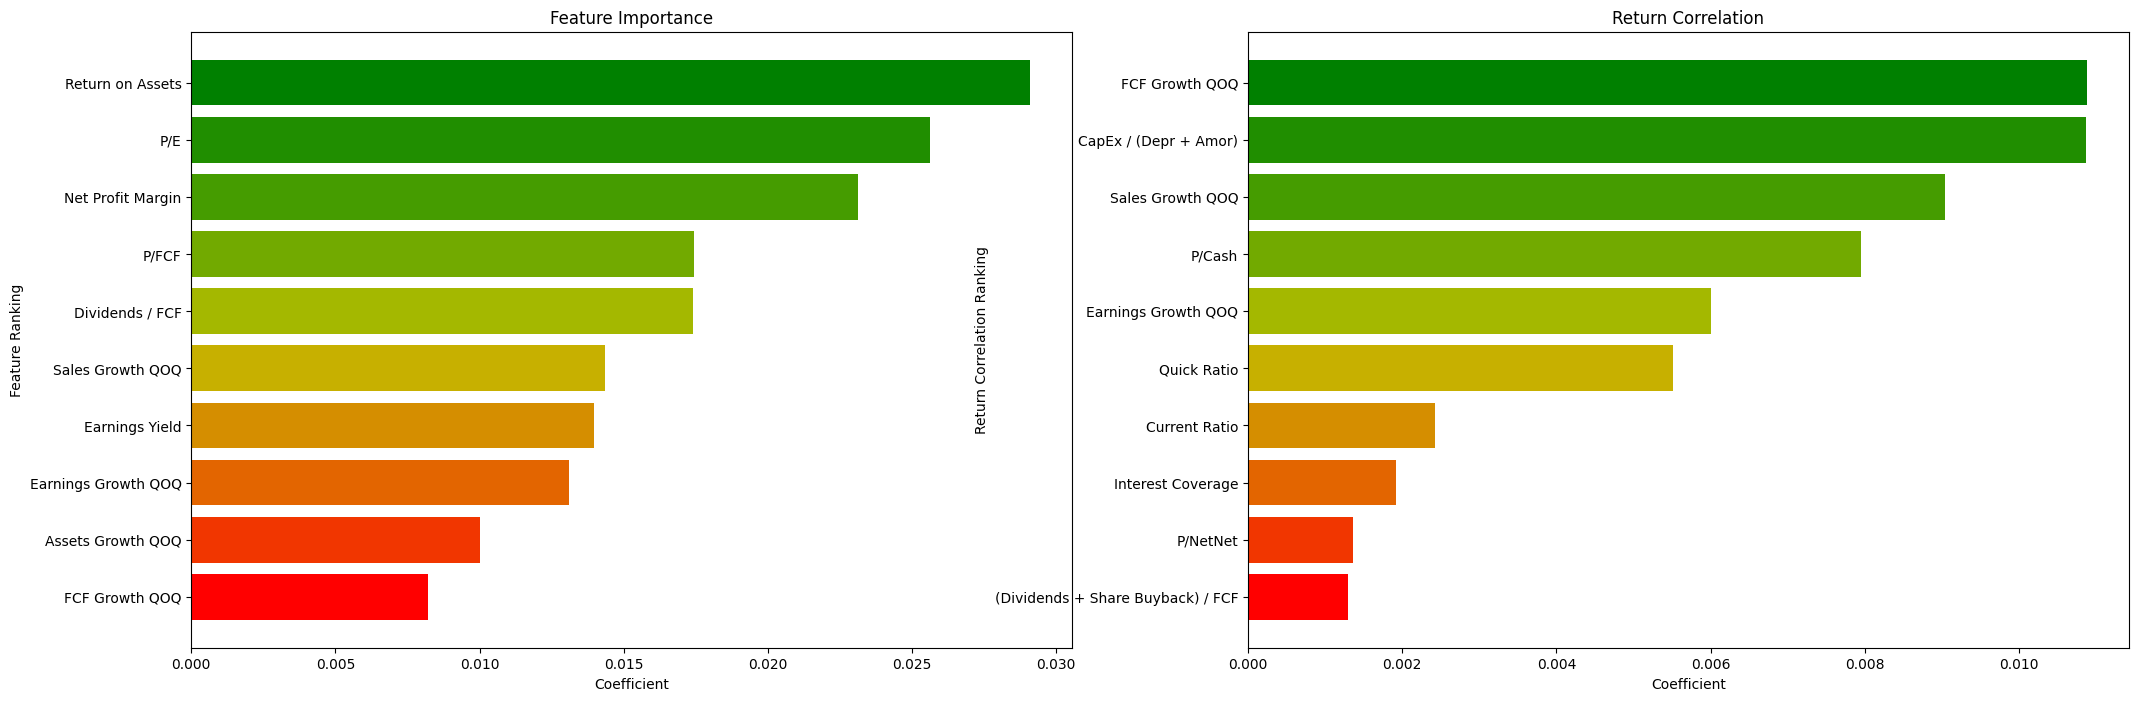

In [ ]:
# your code here
import matplotlib.pyplot as plt
import pandas as pd
from colour import Color
# Plot the feature importances of the forest

## set up the color palettle
red = Color("red")
colors = list(red.range_to(Color("green"),10))
colors = [color.rgb for color in colors]

plt.figure(figsize=(25, 8))
plt.subplot(1,2,1)
plt.title("Feature Importance")
plt.barh(df['index'], df['Feature Importance'], color=colors)
plt.xlabel("Coefficient")
plt.ylabel("Feature Ranking")
plt.title('Feature Importance')

plt.subplot(1,2,2)
plt.title("Return Correlation")
plt.barh(df1['index'], df1['Return Correlation'], color=colors)
plt.xlabel("Coefficient")
plt.ylabel("Return Correlation Ranking")
plt.title('Return Correlation')



***

###**Regression Results**

Let us now see how well the model performs. First we use the fitted model to predict the stock-returns for the training- and test-sets by completing the code below:

In [ ]:
%%time
y_train_pred = regr.predict(X_train)
y_test_pred = regr.predict(X_test)

CPU times: user 6 s, sys: 49 ms, total: 6.04 s
Wall time: 3.2 s


We can then calculate the $R^2$ value (aka. the coefficient of determination) between the actual stock-returns and those predicted by the model. A value of 1 means a perfect prediction, while a value of 0 means the model basically predicted the average stock-return, and a negative value means the model's prediction was worse than just using the average stock-return.


In [ ]:
r2_score(y_true=y_train, y_pred=y_train_pred)

0.8975252344001053

Now we calculate the $R^2$ for the test set.

In [ ]:
r2_score(y_true=y_test, y_pred=y_test_pred)

-0.09812273954625961

#### **Homework Question 2 - Training Set**

Plot the model's predicted versus actual stock returns for stocks in the **training** set.

* **Get a ticker in the training set and plot predicted versus actual**
The code sample below shows how to do this in Plotly. Feel free to use any plotting library.

In [ ]:
# Column-name for the models' predicted stock-returns.
TOTAL_RETURN_PRED = 'Total Return Predicted'

# Create a DataFrame with actual and predicted stock-returns.
# This is for the training-set.
df_y_train = pd.DataFrame(y_train)
df_y_train[TOTAL_RETURN_PRED] = y_train_pred

# Plot the actual and predicted stock-returns for the stock ticker
#ticker = 'COKE' # NOTE: You can specify any ticker in the training set here instead...
ticker = tickers_train[81] # Just grabbing the a random training ticker
my_df = df_y_train.loc[ticker].reset_index().melt(id_vars=['Date'], var_name='Series', value_name='Return')
fig = px.line(my_df, x="Date", y="Return", color='Series')
fig.show()


#### **Question 2 answer here**





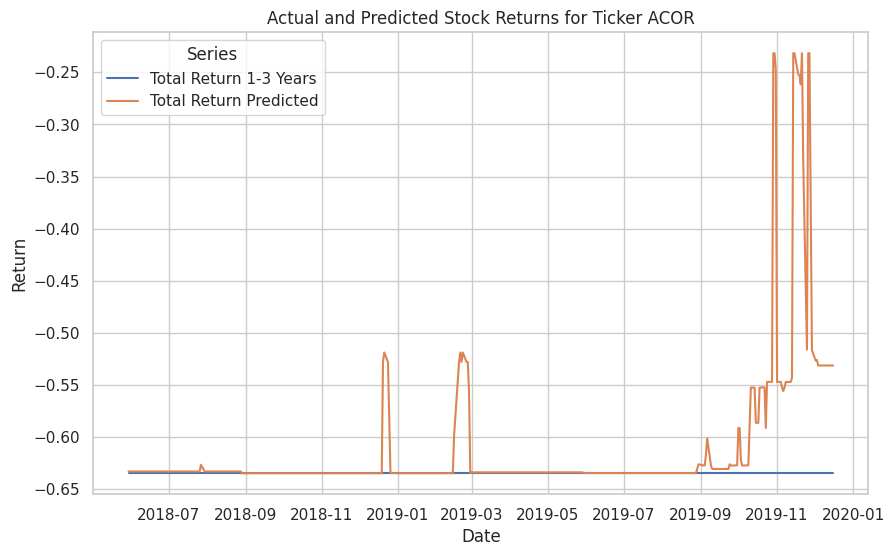

In [ ]:
# question code here using another library
# Set the style for the plot
sns.set(style="whitegrid")

# Set the figure size
plt.figure(figsize=(10, 6))

# Use Seaborn to plot the line chart
sns.lineplot(x='Date', y='Return', hue='Series', data=my_df)

# Set plot title and labels
plt.title(f"Actual and Predicted Stock Returns for Ticker {ticker}")
plt.xlabel("Date")
plt.ylabel("Return")

# Show the plot
plt.show()

#### **Homework Question 3 - Test Set**

Now plot the model's predicted versus actual stock returns for a ticker in the **test** set.

* **Plot actual vs predicted for a ticker in the test set**

How does the actual predicted performance compare to the training set?

In [ ]:
# Create a DataFrame with actual and predicted stock-returns.
# This is for the test-set.
df_y_test = pd.DataFrame(y_test)
df_y_test[TOTAL_RETURN_PRED] = y_test_pred

# Plot the actual and predicted stock-returns for the first stock.
#ticker = 'COKE' # NOTE: You can specify any ticker in the training set here instead...
ticker = tickers_test[10] # pulling the first ticker from the test set
my_df2 = df_y_test.loc[ticker].reset_index().melt(id_vars=['Date'], var_name='Series', value_name='Return')
fig = px.line(my_df2, x="Date", y="Return", color='Series')
fig.show()




#### **Question 3 answer here**

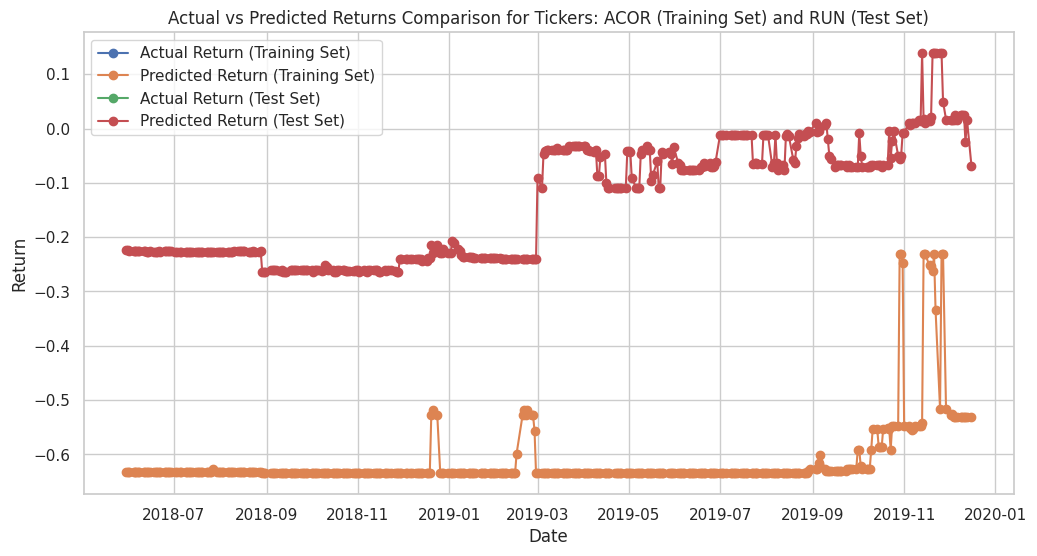

In [ ]:
# Assuming df_y_train, y_train, y_train_pred, df_y_test, y_test, and y_test_pred are already defined as in your code

# Column-name for the models' predicted stock-returns.
TOTAL_RETURN_PRED = 'Total Return Predicted'

# Choose a ticker for comparison
ticker_train = tickers_train[81]  # Choose any ticker in the training set
ticker_test = tickers_test[10]    # Choose any ticker in the test set

# Extract the relevant data for the specified tickers
ticker_data_train = df_y_train.loc[ticker_train].reset_index().melt(id_vars=['Date'], var_name='Series', value_name='Return')
ticker_data_test = df_y_test.loc[ticker_test].reset_index().melt(id_vars=['Date'], var_name='Series', value_name='Return')

# Create a line plot for training set
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(ticker_data_train[ticker_data_train['Series'] == 'Total Return']['Date'],
        ticker_data_train[ticker_data_train['Series'] == 'Total Return']['Return'],
        label='Actual Return (Training Set)', marker='o')

ax.plot(ticker_data_train[ticker_data_train['Series'] == TOTAL_RETURN_PRED]['Date'],
        ticker_data_train[ticker_data_train['Series'] == TOTAL_RETURN_PRED]['Return'],
        label='Predicted Return (Training Set)', marker='o')

# Create a line plot for test set
ax.plot(ticker_data_test[ticker_data_test['Series'] == 'Total Return']['Date'],
        ticker_data_test[ticker_data_test['Series'] == 'Total Return']['Return'],
        label='Actual Return (Test Set)', marker='o')

ax.plot(ticker_data_test[ticker_data_test['Series'] == TOTAL_RETURN_PRED]['Date'],
        ticker_data_test[ticker_data_test['Series'] == TOTAL_RETURN_PRED]['Return'],
        label='Predicted Return (Test Set)', marker='o')

# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Return')
ax.set_title(f'Actual vs Predicted Returns Comparison for Tickers: {ticker_train} (Training Set) and {ticker_test} (Test Set)')
ax.legend()

# Show the plot
plt.show()

Your question answer here

The actual predicted performance suggests a considerable mismatch between the predicted and actual returns for the Total Return 1-3 Years series. The predicted returns, represented by the "Total Return Predicted" values, consistently show negative figures throughout the observed period, while the actual returns demonstrate positive values. This inconsistency suggests that the model used for prediction did not accurately capture the trend and magnitude of the actual returns during this period.


## Machine Learning: Classification

Instead of mapping from signals x to a continuous variable y for the stock-return, we can try and map to discrete output classes that indicate if the stock return was a gain or loss (i.e. positive or negative). This is a so-called **binary classification** problem, and perhaps an easier problem to model.

First we need to convert the stock-returns into values of either 1.0 for gains or -1.0 for losses, and then split into training- and test-sets:

In [ ]:
%%time
# Convert stock-returns to binary classes by taking the sign.
df_cls = np.sign(df_sig_rets[TOTAL_RETURN_1_3Y])

# Split the classes into training- and test-sets.
y_train_cls = df_cls.loc[tickers_train]
y_test_cls = df_cls.loc[tickers_test]

CPU times: user 454 ms, sys: 0 ns, total: 454 ms
Wall time: 470 ms


The training-set is biased because it contains many more stocks with gains than losses:

In [ ]:
# Fraction of the training-set that is classified as gains.
(y_train_cls == 1.0).sum() / len(y_train_cls)

0.6048370688556884

We instruct the Machine Learning model to take this bias into account, by setting `class_weight='balanced'`, and otherwise use the same arguments as above:

In [ ]:
clf = RandomForestClassifier(class_weight='balanced', **model_args)

We can then fit the model to the training-data.

In [ ]:
%%time
_ = clf.fit(X=X_train, y=y_train_cls)

CPU times: user 4min 52s, sys: 543 ms, total: 4min 52s
Wall time: 2min 51s


Similar to the regression model above, the Random Forest consists of 100 Decision Trees, which are basically just nested if-then-else statements that split the input signals, to try and find a mapping that fits the input and output of the training-data. Notice that the classification model takes significantly less time than the regression model.

#### **Printing the model**

We can look at the resulting decision trees used in the random forest ensemble just as before using the same helper functions.

In [ ]:
print_tree(clf, 12) # print the 12th tree from the classification ensemble

|--- Log_Revenue <= 9.62
|   |--- Return_on_Assets <= 0.04
|   |   |--- P/NetNet <= -0.10
|   |   |   |--- Price_to_Book_Value <= 2.88
|   |   |   |   |--- P/Sales <= 8.32
|   |   |   |   |   |--- Interest_Coverage <= 1.55
|   |   |   |   |   |   |--- Return_on_Equity <= -1.09
|   |   |   |   |   |   |   |--- truncated branch of depth 9
|   |   |   |   |   |   |--- Return_on_Equity >  -1.09
|   |   |   |   |   |   |   |--- truncated branch of depth 9
|   |   |   |   |   |--- Interest_Coverage >  1.55
|   |   |   |   |   |   |--- Gross_Profit_Margin <= 0.37
|   |   |   |   |   |   |   |--- truncated branch of depth 9
|   |   |   |   |   |   |--- Gross_Profit_Margin >  0.37
|   |   |   |   |   |   |   |--- truncated branch of depth 9
|   |   |   |   |--- P/Sales >  8.32
|   |   |   |   |   |--- Earnings_Yield <= -0.02
|   |   |   |   |   |   |--- Log_Revenue <= 7.56
|   |   |   |   |   |   |   |--- truncated branch of depth 7
|   |   |   |   |   |   |--- Log_Revenue >  7.56
|   |   |   |

### Model feature importance

We can also show the signals (or features) that the model found were most important.

In [ ]:
compare_feature_imp_corr(clf)

,Feature Importance,Return Correlation
Market-Cap,0.065621,0.107030
Log Revenue,0.064766,0.076307
Gross Profit Margin,0.061519,0.012664
Asset Turnover,0.050465,0.096447
P/Sales,0.046901,0.013084
Interest Coverage,0.045418,0.001862
Price to Book Value,0.044484,0.115539
Current Ratio,0.041816,0.000912
CapEx / (Depr + Amor),0.040210,0.010841
Return on Equity,0.039122,0.101852


In [ ]:
clf_featimportance = compare_feature_imp_corr(clf)
regr_featimportance = compare_feature_imp_corr(regr)

In [ ]:
clf_featimportance.columns = ["classification features", "return correlation"]
regr_featimportance.columns = ["regression features", "return correlation"]
clf_featimportance = clf_featimportance.reset_index()
regr_featimportance = regr_featimportance.reset_index()

In [ ]:
regr_featimportance

,index,regression features,return correlation
0,Gross Profit Margin,0.091203,0.012664
1,Log Revenue,0.068419,0.076307
2,P/Sales,0.064750,0.013084
3,Interest Coverage,0.054834,0.001862
4,Asset Turnover,0.054305,0.096447
5,CapEx / (Depr + Amor),0.053773,0.010841
6,Price to Book Value,0.049638,0.115539
7,Market-Cap,0.048289,0.107030
8,Quick Ratio,0.045826,0.003659
9,Return on Equity,0.042478,0.101852


In [ ]:
all_feature_rankings = clf_featimportance.merge(regr_featimportance, on="index")

In [ ]:
all_feature_rankings = all_feature_rankings.sort_values(by = "classification features", ascending=True)

In [ ]:
all_feature_rankings

,index,classification features,return correlation_x,regression features,return correlation_y
26,FCF Growth QOQ,0.016789,0.010963,0.011091,0.010963
25,Earnings Growth QOQ,0.018508,0.005428,0.009786,0.005428
24,Sales Growth QOQ,0.019030,0.009509,0.013350,0.009509
23,Assets Growth QOQ,0.020748,0.042710,0.013207,0.042710
22,Dividends / FCF,0.026428,0.012350,0.016849,0.012350
21,Earnings Yield,0.026721,0.076306,0.017579,0.076306
20,P/FCF,0.027249,0.053017,0.021372,0.053017
19,FCF Yield,0.028433,0.071203,0.028548,0.071203
18,P/E,0.029232,0.019259,0.030809,0.019259
17,(Dividends + Share Buyback) / FCF,0.030553,0.000945,0.026150,0.000945


## Homework question 4 - Comparing rankings Optional
Using the `all_feature_rankings` variable, create a plot that compares the rankings of feature importance between the classification and regression model.


#### Question 4 answer here

Text(0.5, 1.0, 'Feature Importance')

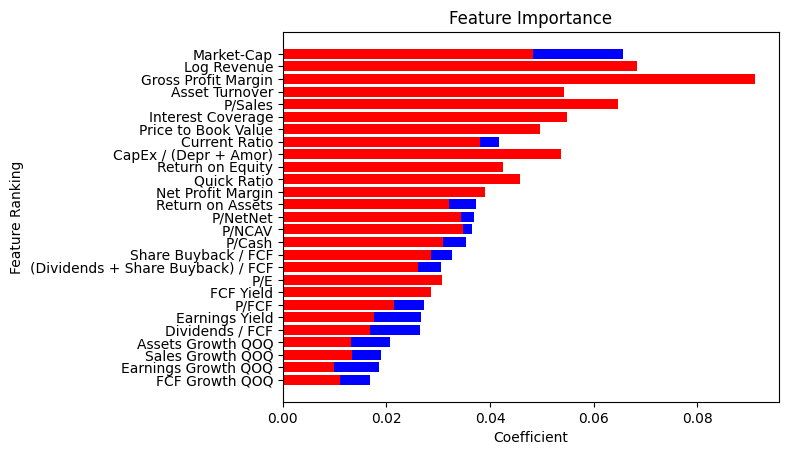

In [ ]:
#your code here

# your code here
import matplotlib.pyplot as plt
import pandas as pd
from colour import Color
# Plot the feature importances of the forest

## set up the color palettle
red = Color("red")
colors = list(red.range_to(Color("green"),10))
colors = [color.rgb for color in colors]

plt.figure()
plt.title("Feature Importance")
plt.barh(all_feature_rankings['index'], all_feature_rankings['classification features'], color="blue")
plt.barh(all_feature_rankings['index'], all_feature_rankings['regression features'], color="red")

plt.xlabel("Coefficient")
plt.ylabel("Feature Ranking")
plt.title('Feature Importance')

#### instructor's comments: Thanks for the excellent jobm the charts look great.

### **Classification Results**

We can then use the fitted model to predict the classes for the training- and test-sets:

In [ ]:
%%time
y_train_pred_cls = clf.predict(X_train)
y_test_pred_cls = clf.predict(X_test)

CPU times: user 9.03 s, sys: 58.1 ms, total: 9.09 s
Wall time: 6.37 s


#### Confusion Matrix

To visualize the classification model results we plot the Confusion Matrix, which shows how the classes were predicted for the training set.

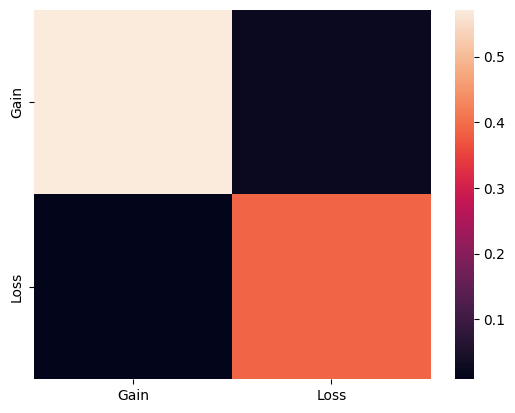

In [ ]:
plot_confusion_matrix(y_true=y_train_cls, y_pred = y_train_pred_cls)

#### **Homework Question 5** Optional

* **Plot the confusion matrix for the test set** and comment on the performance of the classification model.

#### **Question 5 answer here**

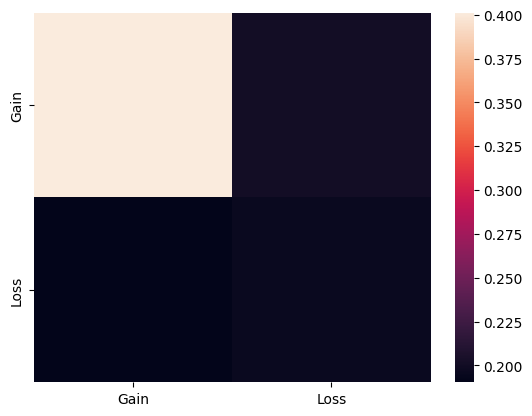

In [ ]:
# your code here
plot_confusion_matrix(y_true=y_test_cls, y_pred = y_test_pred_cls)


## **Explaining the models**

Neither the classification or regression models performed particularly well given their performance against the test set. Both models utilized different attributes and features of the input data in order to make their determinations. While we can view the individual decision trees that make up the random forest ensembles, it is sometimes quicker to use "explainer" methods in order to improve and compare models.

In the code below, we make use of the Lime package to visualize the impact of the features and feature values on each of the models. This is a quick way to open up black box models and set the basis for conversations around feature selection, feature transformations, modeling methods, and more.



In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=6c4525cec135a1ff95767f0f005b5815b1338eb4c2d3f37dc3d046b4ba5ebf76
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
from lime.lime_tabular import LimeTabularExplainer

In [ ]:
explainer = LimeTabularExplainer(X_train.values, mode="regression", feature_names=X_train.columns)

In [ ]:
i = 0
X_observation = X_test.iloc[[i], :]

In [ ]:
explanation = explainer.explain_instance(X_observation.values[0], regr.predict)
explanation.show_in_notebook(show_table=True, show_all=False)
print(explanation.score)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names



0.049017100212727205


Each feature’s contribution to this prediction is shown in the right bar plot. Orange signifies the positive impact and blue signifies the negative impact of that feature on the target.

In [ ]:
explanation = explainer.explain_instance(X_observation.values[0], clf.predict)
explanation.show_in_notebook(show_table=True, show_all=False)
print(explanation.score)

## Discussion

In this rather long and complex script, we used a Random Forest to automatically model the relation between signals and future stock-returns. We created both a regression and classification model for comparison. By visualizing each step of the analysis, you were able to visually understand the:
* structure of the data
* cleanliness of the input data set
* feature importance
* model results


In reality, a company's earnings statements including the balance sheet, income statement, and cash flow comes many months after financial impacts to a company actually occurred.  So, by the time the information hits the general public, that information has already been incorporated in a stock's price months earlier. However, this is overall a very realistic first draft at a trading model using decision trees with fairly sophisticated features.

Without having to understand all those details, you were able to run the model and characterize the results. The training sets had extremely good performance while both the regression and classification models failed in the test data set.

In general, these experiments show that machine learning cannot replace domain expertise. Even if the ML model had performed well on the test-data, it would not have provided an explanation for the underlying relation between signals and stock-returns. Nevertheless, the decision tree output is probably one of the more explainable ML models. Consequently, being able to visualize and communicate the inner workings of the model is an increasingly important skill particularly when the domain experts and the data scientists are not one and the same.




### Predicting Long-Term Stock Returns

When it comes to predicting long-term stock-returns, there are actually only 3 factors that matter: The future dividends, sales-growth, and change in the Price/Sales valuation ratio. (You could instead use earnings-growth or book-value growth, and the price/earnings or price/book valuation ratios.) If we can predict the future dividend, sales-growth and price/sales ratio, then we can predict the future stock-return.

In any case, **take into consideration the need for domain-expertise before applying any ML methods to complex problems. Visualization methods are one way by which domain experts and data scientists can more easily collaborate in a common language.**


## License (MIT)

This is published under the
[MIT License](https://github.com/simfin/simfin-tutorials/blob/master/LICENSE.txt)
which allows very broad use for both academic and commercial purposes.

You are very welcome to modify and use this source-code in your own project. Please keep a link to the [original repository](https://github.com/simfin/simfin-tutorials).
